## CV classification task on CIFAR dataset

### Importing modules

In [1]:
import os
logs_base_dir = 'runs'
os.makedirs(logs_base_dir, exist_ok=True)

In [2]:
import copy
import torch
import torch.nn as nn
import torchvision
import torchvision.models as models
import torchvision.transforms as transforms
import torchsummary
from torch.utils.tensorboard import SummaryWriter
from IPython.display import clear_output
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
import numpy as np
import warnings
import random
warnings.filterwarnings('ignore')
plt.style.use('ggplot')

In [3]:
! pip install albumentations==0.5.1

     |████████████████████████████████| 81kB 6.0MB/s 
     |████████████████████████████████| 36.7MB 92kB/s 
     |████████████████████████████████| 952kB 47.5MB/s 
  Found existing installation: imgaug 0.2.9
    Uninstalling imgaug-0.2.9:
      Successfully uninstalled imgaug-0.2.9
  Found existing installation: albumentations 0.1.12
    Uninstalling albumentations-0.1.12:
      Successfully uninstalled albumentations-0.1.12


### Loading and preparing the data

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
!cp 'drive/My Drive/Colab Notebooks/CV/Classification/utils.py' .
!cp 'drive/My Drive/Colab Notebooks/CV/Classification/models/resnet50.py' .

In [6]:
import utils
import imp
imp.reload(utils)

<module 'utils' from '/content/utils.py'>

In [7]:
from utils import train_model

In [8]:
def mkdir(path):
    if not os.path.exists(root_path):
        os.mkdir(root_path)
        print('Directory', path, 'is created!')
    else:
        print('Directory', path, 'already exists!')

In [9]:
root_path = '/content/cifar10'
mkdir(root_path)

Directory /content/cifar10 is created!


In [10]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [11]:
NUM_WORKERS = 4
BATCH_SIZE = 128
VAL_RATIO = 0.2

In [12]:
# normalize = transforms.Normalize(mean=[0.4914, 0.4822, 0.4465], 
#                                  std=[0.2023, 0.1994, 0.2010])

# transform = transforms.Compose([transforms.ToTensor(), normalize])
    
# dataset = torchvision.datasets.CIFAR10(root=root_path,
#                                        train=True,
#                                        transform=transform,
#                                        download=True)

# val_size = int(len(dataset) * VAL_RATIO)
# train_size = len(dataset) - val_size
# train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

# test_dataset = torchvision.datasets.CIFAR10(root=root_path,
#                                             train=False,
#                                             transform=transform,
#                                             download=True)

# train_loader = torch.utils.data.DataLoader(train_dataset, BATCH_SIZE, shuffle=True, num_workers=4, pin_memory=True)
# val_loader = torch.utils.data.DataLoader(val_dataset, BATCH_SIZE*2, num_workers=4, pin_memory=True)
# test_loader = torch.utils.data.DataLoader(test_dataset, BATCH_SIZE*2, num_workers=4, pin_memory=True)

In [13]:
train_loader, val_loader = utils.get_train_val_loader(data_dir=root_path,
                                                      batch_size=BATCH_SIZE,
                                                      val_size=VAL_RATIO,
                                                      num_workers=NUM_WORKERS)

test_loader = utils.get_test_loader(data_dir=root_path,
                                    batch_size=BATCH_SIZE,
                                    num_workers=NUM_WORKERS)

Extracting /content/cifar10/cifar-10-python.tar.gz to /content/cifar10
Files already downloaded and verified
Files already downloaded and verified


### Testing `ResNet50` implemented from scratch

In [17]:
import resnet50
imp.reload(resnet50)

<module 'resnet50' from '/content/resnet50.py'>

In [15]:
resnet50_model = resnet50.ResNet50(resnet50.ConvBlock, num_classes=10)

In [16]:
resnet50_model.to(device)

ResNet50(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (block_layer1): Sequential(
    (0): ConvBlock(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (res_connection): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (relu): ReLU(in

In [17]:
N_EPOCHS = 10
opt = torch.optim.Adam(resnet50_model.parameters(), lr=3e-3)
criterion = nn.CrossEntropyLoss()
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer=opt, T_max=100)

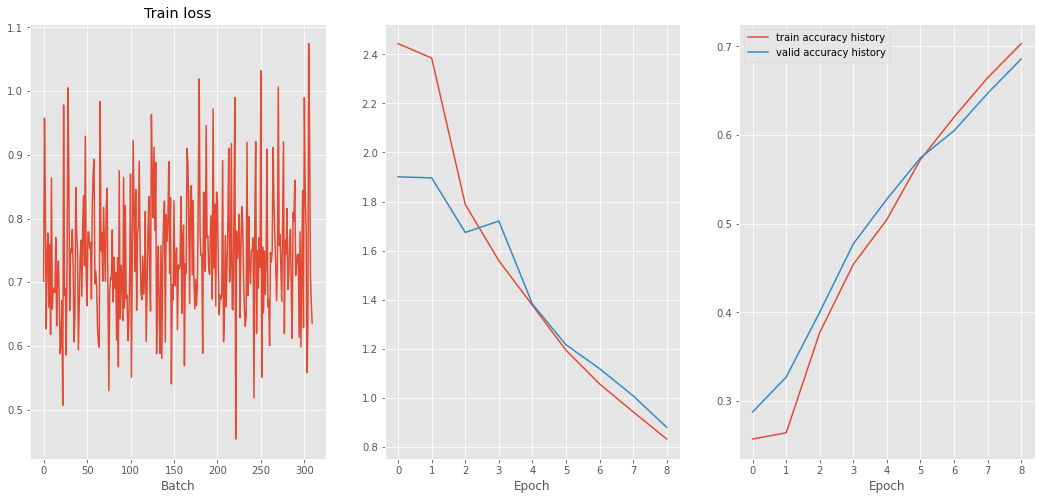

Epoch: 10 | Time: 2m 51s
	Train Loss: 0.742
	 Val. Loss: 0.879


In [18]:
train_model(resnet50_model, 
            device, 
            train_loader, 
            val_loader, 
            opt, 
            criterion, 
            lr_scheduler, 
            N_EPOCHS, 
            clip=1, 
            model_name='resnet50_model.pth')

### Testing pretrained models

Let's use some prepared [models for classification](https://pytorch.org/docs/stable/torchvision/models.html#classification) from torchvision. We will apply pretrained versions of models to use them as feature extractors and also train these models from scratch to compare their perfomances.

#### Densenet-201

##### Pretrained

In [19]:
densenet201_pr = models.densenet201(pretrained=True)

Downloading: "https://download.pytorch.org/models/densenet201-c1103571.pth" to /root/.cache/torch/hub/checkpoints/densenet201-c1103571.pth


In [20]:
# freezing all the network's weights except the final dense layer to use the 
# net as a fixed feature extractor

for param in densenet201_pr.parameters():
    param.requires_grad = False

fc_in = densenet201_pr.classifier.in_features
densenet201_pr.classifier = nn.Linear(fc_in, 10)

densenet201_pr.to(device)

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [21]:
N_EPOCHS = 10
opt = torch.optim.Adam(densenet201_pr.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer=opt, step_size=2, gamma=0.1)

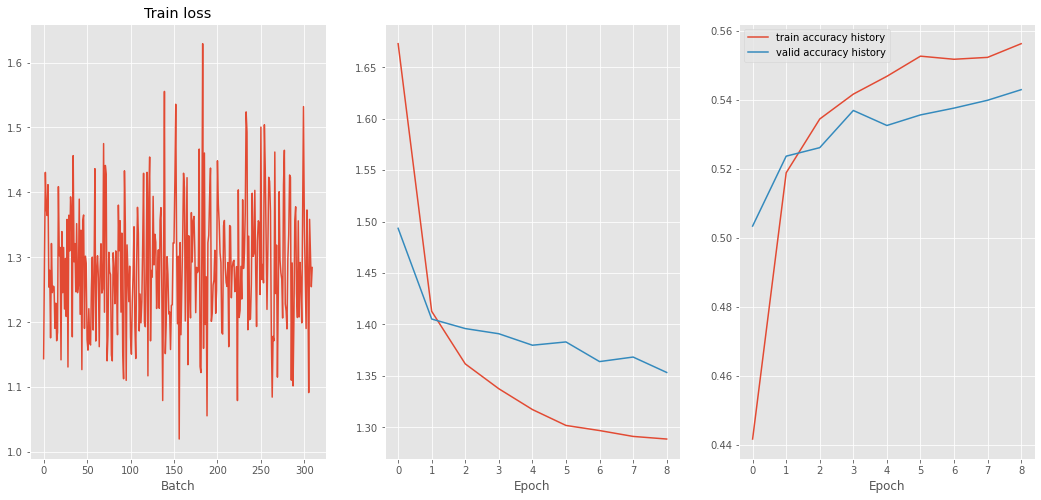

Epoch: 10 | Time: 1m 5s
	Train Loss: 1.283
	 Val. Loss: 1.366


In [22]:
train_model(densenet201_pr,
            device,
            train_loader,
            val_loader,
            opt,
            criterion,
            lr_scheduler,
            N_EPOCHS,
            clip=1,
            model_name='densenet_201_pr.pth')

##### Training from scratch

In [23]:
densenet201 = models.densenet201(pretrained=False)

In [24]:
fc_in = densenet201.classifier.in_features
densenet201.classifier = nn.Sequential(
    nn.Linear(fc_in, 256),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(256, 10),
)

densenet201.to(device)

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [25]:
N_EPOCHS = 10
opt = torch.optim.Adam(densenet201.parameters(), lr=3e-3)
criterion = nn.CrossEntropyLoss()
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer=opt, step_size=3, gamma=0.1)

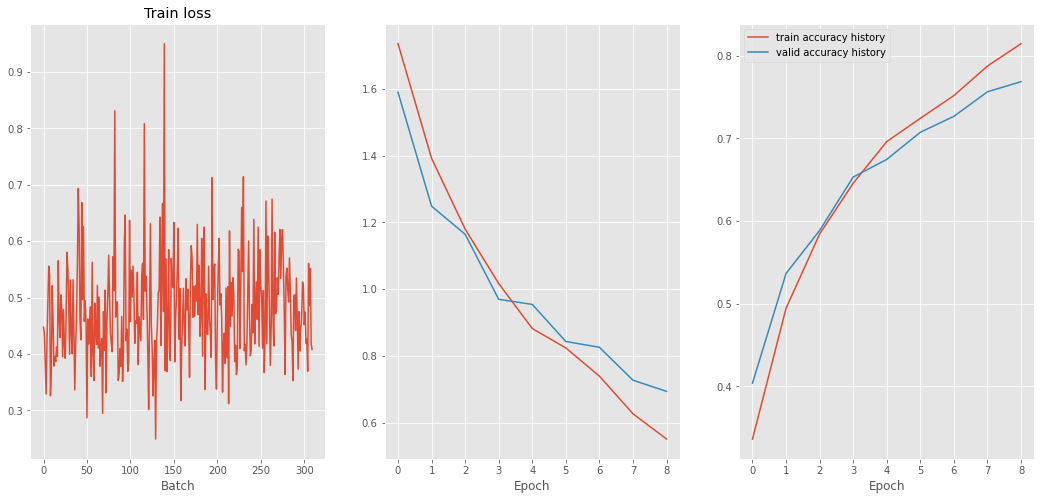

Epoch: 10 | Time: 3m 13s
	Train Loss: 0.479
	 Val. Loss: 0.775


In [26]:
train_model(densenet201,
            device,
            train_loader,
            val_loader,
            opt,
            criterion,
            lr_scheduler,
            N_EPOCHS,
            clip=1,
            model_name='densenet201.pth')

#### MobileNet V2

##### Pretrained

Let's freeze all the network's weights except the final layers.

In [27]:
mobilenet_pr_fr = models.mobilenet_v2(pretrained=True)

Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth


In [28]:
# freezing all the network's weights except the final dense layer to use the 
# net as a fixed feature extractor

for param in mobilenet_pr_fr.parameters():
    param.requires_grad = False

fc_in = mobilenet_pr_fr.classifier[1].in_features
mobilenet_pr_fr.classifier = nn.Sequential(
    nn.Linear(fc_in, 256),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(256, 10),
)

mobilenet_pr_fr.to(device)

MobileNetV2(
  (features): Sequential(
    (0): ConvBNReLU(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNReLU(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNReLU(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=Tr

In [29]:
N_EPOCHS = 10
opt = torch.optim.Adam(mobilenet_pr_fr.parameters(), lr=3e-3)
criterion = nn.CrossEntropyLoss()
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer=opt, step_size=4, gamma=0.1)

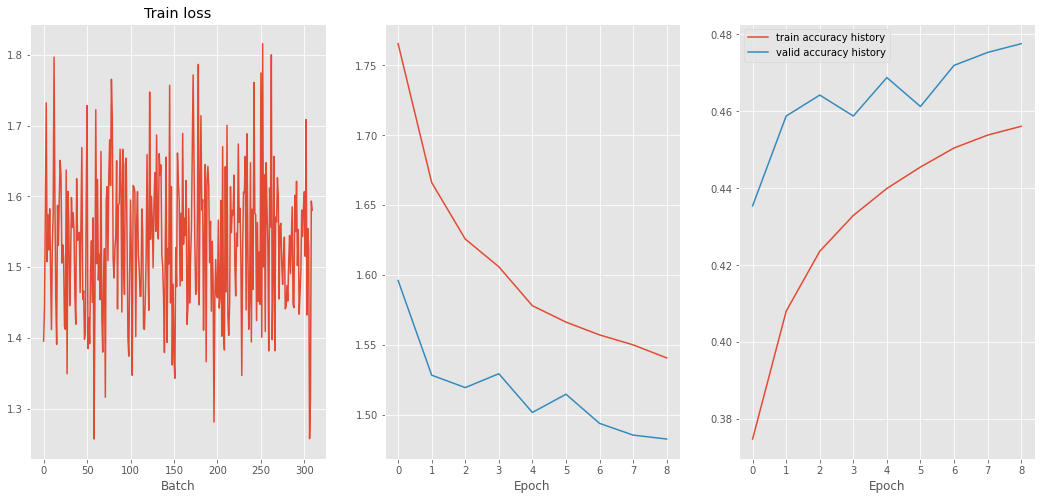

Epoch: 10 | Time: 0m 35s
	Train Loss: 1.533
	 Val. Loss: 1.486


In [30]:
train_model(mobilenet_pr_fr,
            device,
            train_loader,
            val_loader,
            opt,
            criterion,
            lr_scheduler,
            N_EPOCHS,
            clip=1,
            model_name='mobilenet_pr_fr.pth')

Now we won't freeze the weights and allow backpropagation through all layers. 

In [31]:
mobilenet_pr = models.mobilenet_v2(pretrained=True)

In [32]:
# freezing all the network's weights except the final dense layer to use the 
# net as a fixed feature extractor

# for param in mobilenet_pr.parameters():
#     param.requires_grad = False

fc_in = mobilenet_pr.classifier[1].in_features
mobilenet_pr.classifier = nn.Sequential(
    nn.Linear(fc_in, 256),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(256, 10),
)

mobilenet_pr.to(device)

MobileNetV2(
  (features): Sequential(
    (0): ConvBNReLU(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNReLU(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNReLU(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=Tr

In [33]:
N_EPOCHS = 10
opt = torch.optim.Adam(mobilenet_pr.parameters(), lr=3e-3)
criterion = nn.CrossEntropyLoss()
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer=opt, step_size=4, gamma=0.1)

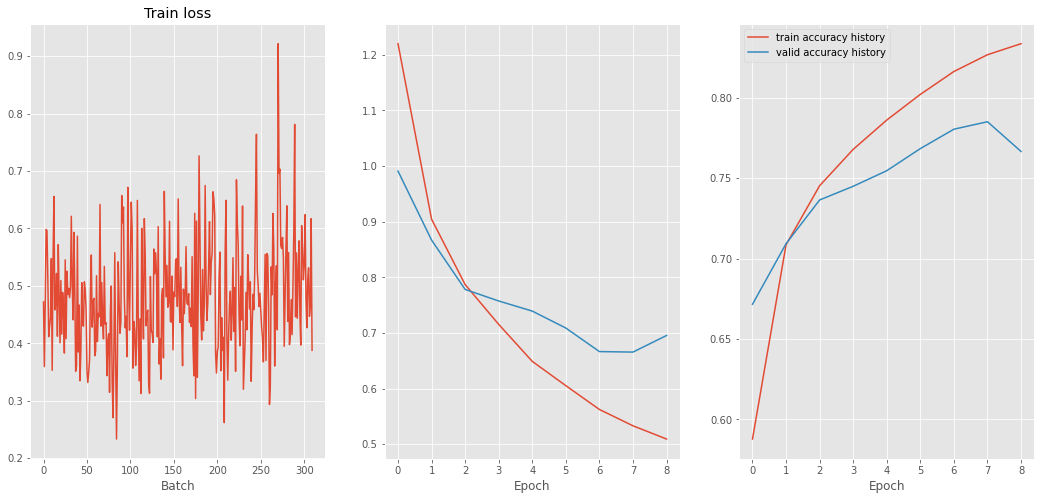

Epoch: 10 | Time: 1m 0s
	Train Loss: 0.480
	 Val. Loss: 0.644


In [34]:
train_model(mobilenet_pr,
            device,
            train_loader,
            val_loader,
            opt,
            criterion,
            lr_scheduler,
            N_EPOCHS,
            clip=1,
            model_name='mobilenet_pr.pth')

##### Training from scratch

In [35]:
mobilenet = models.mobilenet_v2(pretrained=False)

In [36]:
fc_in = mobilenet.classifier[1].in_features
mobilenet.classifier[1] = nn.Sequential(
    nn.Linear(fc_in, 256),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(256, 10),
)

mobilenet.to(device)

MobileNetV2(
  (features): Sequential(
    (0): ConvBNReLU(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNReLU(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNReLU(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=Tr

In [37]:
N_EPOCHS = 10
opt = torch.optim.Adam(mobilenet.parameters(), lr=3e-3)
criterion = nn.CrossEntropyLoss()
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer=opt, step_size=4, gamma=0.1)

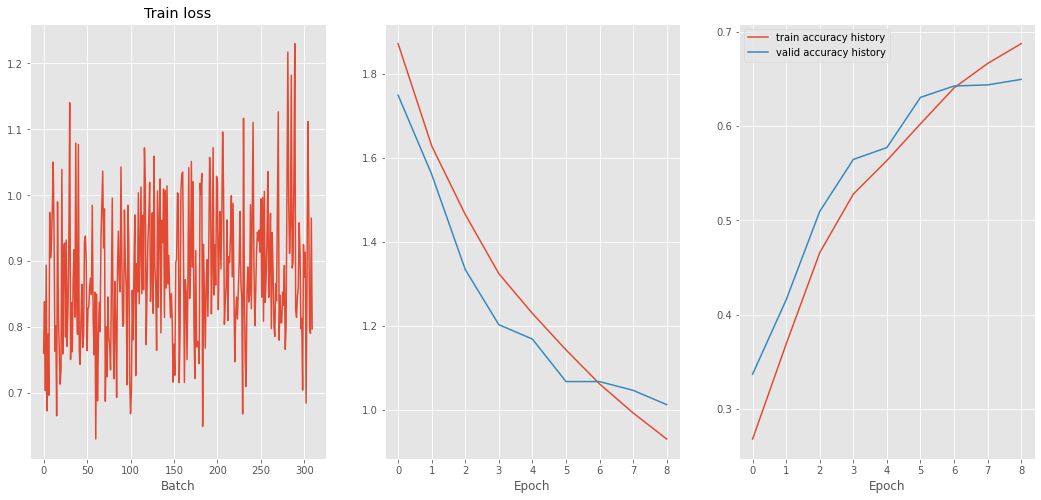

Epoch: 10 | Time: 1m 0s
	Train Loss: 0.878
	 Val. Loss: 0.930


In [38]:
train_model(mobilenet,
            device,
            train_loader,
            val_loader,
            opt,
            criterion,
            lr_scheduler,
            N_EPOCHS,
            clip=1,
            model_name='mobilenet.pth')

In [18]:
model = resnet50.ResNet50(resnet50.ConvBlock, num_classes=10)
model_save_name = 'resnet50_model.pth'
path = F"/content/drive/My Drive/Colab Notebooks/CV/Classification/{model_save_name}"
model.load_state_dict(torch.load(path))

<All keys matched successfully>

### Adding augmentations from `albumentations`

In [14]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

In [15]:
train_transform = A.Compose(
    [
        A.Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.2023, 0.1994, 0.2010)),
        # A.HorizontalFlip(p=0.5),
        A.RandomBrightnessContrast(),
        # A.CLAHE(p=1.0, clip_limit=2.0),
        # A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.1, 
        #                    rotate_limit=15),
        ToTensorV2(),
    ]
)

val_transform = A.Compose(
    [
        A.Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.2023, 0.1994, 0.2010)),
        ToTensorV2(),
    ]
)

train_aug_loader, val_aug_loader = utils.get_train_val_loader(data_dir=root_path,
                                                              batch_size=BATCH_SIZE,
                                                              train_transform=train_transform,
                                                              val_transform=val_transform)

Files already downloaded and verified
Files already downloaded and verified


In [16]:
mobilenet_aug = models.mobilenet_v2(pretrained=True)

Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth


In [17]:
fc_in = mobilenet_aug.classifier[1].in_features
mobilenet_aug.classifier = nn.Sequential(
    nn.Linear(fc_in, 256),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(256, 10),
)

mobilenet_aug.to(device)

MobileNetV2(
  (features): Sequential(
    (0): ConvBNReLU(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNReLU(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNReLU(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=Tr

In [18]:
N_EPOCHS = 10
opt = torch.optim.Adam(mobilenet_aug.parameters(), lr=3e-3)
criterion = nn.CrossEntropyLoss()
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer=opt, step_size=3, gamma=0.1)

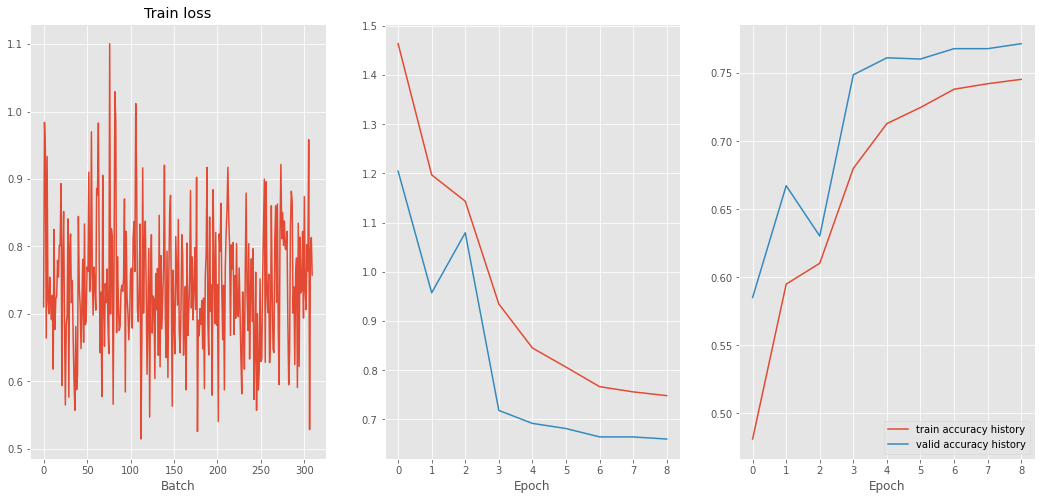

Epoch: 10 | Time: 0m 38s
	Train Loss: 0.742
	 Val. Loss: 0.661


In [19]:
train_model(mobilenet_aug,
            device,
            train_aug_loader,
            val_aug_loader,
            opt,
            criterion,
            lr_scheduler,
            N_EPOCHS,
            clip=1,
            model_name='mobilenet_aug.pth')

### Automatic mixed precision

In [20]:
mobilenet_amp = models.mobilenet_v2(pretrained=True)

In [21]:
fc_in = mobilenet_amp.classifier[1].in_features
mobilenet_amp.classifier = nn.Sequential(
    nn.Linear(fc_in, 256),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(256, 10),
)

mobilenet_amp.to(device)

MobileNetV2(
  (features): Sequential(
    (0): ConvBNReLU(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNReLU(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNReLU(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=Tr

In [22]:
N_EPOCHS = 10
opt = torch.optim.Adam(mobilenet_amp.parameters(), lr=3e-3)
criterion = nn.CrossEntropyLoss()
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer=opt, step_size=3, gamma=0.1)

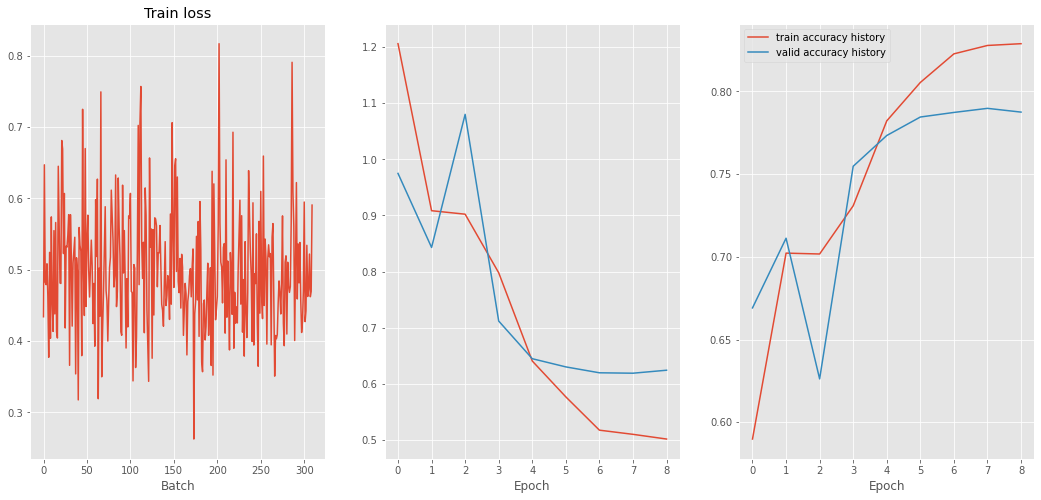

Epoch: 10 | Time: 0m 38s
	Train Loss: 0.499
	 Val. Loss: 0.620


In [23]:
train_model(mobilenet_amp,
            device,
            train_loader,
            val_loader,
            opt,
            criterion,
            lr_scheduler,
            N_EPOCHS,
            clip=1,
            enable_mixed_precision=True,
            model_name='mobilenet_aug.pth')

In [ ]:
! cp mobilenet.pth 'drive/My Drive/Colab Notebooks/CV/Classification/'
! cp mobilenet_pr.pth 'drive/My Drive/Colab Notebooks/CV/Classification/'
! cp mobilenet_pr_fr.pth 'drive/My Drive/Colab Notebooks/CV/Classification/'
! cp mobilenet_aug.pth 'drive/My Drive/Colab Notebooks/CV/Classification/'
! cp mobilenet_amp.pth 'drive/My Drive/Colab Notebooks/CV/Classification/'
! cp densenet201.pth 'drive/My Drive/Colab Notebooks/CV/Classification/'
! cp densenet_201_pr.pth 'drive/My Drive/Colab Notebooks/CV/Classification/'
! cp resnet50_model.pth 'drive/My Drive/Colab Notebooks/CV/Classification/'

In [147]:
imp.reload(utils)
from utils import train_model

In [ ]:
# writer = SummaryWriter() 

In [ ]:
# %load_ext tensorboard
# %tensorboard --logdir runs